In [2]:
from util.trajectories import *
from util.guided_ot import *
from util.simplicial_paths import *

# Functions

In [2]:
def dijkstra_tree(SC, best_path, other_paths, ref_path_class, colors=['green', 'red', 'blue'], plot_others=False, figsize=(5,5)):
    shortest_class = Trajectory_Class(SC)
    shortest_class.add_path(best_path)
    other_class = Trajectory_Class(SC)

    for path in other_paths:
        other_class.add_path(path)

    holder = Trajectory_Holder(SC)

    if plot_others:
        holder.add_class(other_class, None, 'others', colors[0])
        
    holder.add_class(ref_path_class, None, 'reference', colors[1])
    holder.add_class(shortest_class, None, 'result', colors[2])

    holder.plot_paths(True, figsize=figsize)
    holder.plot_projections(figsize=figsize)
    plt.show()

    return holder

def get_node_weights(path):
    return path.path_length

def get_path_proj_diff(path, ref_proj, norm_type=1):
    return np.round(np.linalg.norm(path.edge_projections - ref_proj, norm_type, axis=1), 10)

def compute_costs(path, ref_proj, alpha, norm_type):
    edge_weights = np.hstack([np.array([0]), get_node_weights(path)])
    proj_diffs = get_path_proj_diff(path, ref_proj, norm_type)
    return edge_weights, proj_diffs, edge_weights + alpha * proj_diffs

def compare_path_perf(path1, path2, ref_proj, alpha, norm_type=1):
    num_nodes_path1, num_nodes_path2 = len(path1.nodes), len(path2.nodes)
    len_diff = np.abs(num_nodes_path1 - num_nodes_path2)
    shorter_path = np.argmin([ num_nodes_path1, num_nodes_path2 ])
    path1_costs = compute_costs(path1, ref_proj, alpha, norm_type)
    path2_costs = compute_costs(path2, ref_proj, alpha, norm_type)
    
    if len_diff == 0:
        return path1_costs, path2_costs
    elif shorter_path == 0:
        edge_cost = np.ones(num_nodes_path2) * path1_costs[0][-1]
        edge_cost[:num_nodes_path1] = path1_costs[0]

        proj_cost = np.ones(num_nodes_path2) * path1_costs[1][-1]
        proj_cost[:num_nodes_path1] = path1_costs[1]

        total_cost = np.ones(num_nodes_path2) * path1_costs[2][-1]
        total_cost[:num_nodes_path1] = path1_costs[2]

        path1_costs = edge_cost, proj_cost, total_cost
    else:
        edge_cost = np.ones(num_nodes_path1) * path2_costs[0][-1]
        edge_cost[:num_nodes_path2] = path2_costs[0]

        proj_cost = np.ones(num_nodes_path1) * path2_costs[1][-1]
        proj_cost[:num_nodes_path2] = path2_costs[1]

        total_cost = np.ones(num_nodes_path1) * path2_costs[2][-1]
        total_cost[:num_nodes_path2] = path2_costs[2]

        path2_costs = edge_cost, proj_cost, total_cost

    return path1_costs, path2_costs

def plot_proj_diff(path1, path2):
    path1_costs, path2_costs = compare_path_perf(path1, path2, path2.edge_projections[-1], 0)
    path1_costs, path2_costs = path1_costs[1], path2_costs[1]
    colors = ["red", "blue"]
    x_axis = np.arange(np.max([len(path1.nodes), len(path2.nodes)]))
    plt.plot(x_axis, path1_costs, color=colors[0], marker="1")
    plt.plot(x_axis, path2_costs, color=colors[1], marker="2")
    plt.xlabel('Path node')
    plt.ylabel('Projection difference')
    plt.legend(["reference path", "resulting path"])

In [3]:
def proj_descent(SC, start, end, ref_proj, extra, ord=1, max_iter=1000):
    dim_proj = SC.H_extra.shape[0] if extra else SC.H.shape[0]
    curr_proj = np.zeros(dim_proj)
    curr_node = start
    prev_node = None
    visited = [start]

    def get_next_proj(u, v, curr_proj):
        edge = Trajectory(SC, [u,v], extra)
        proj = edge.edge_projections[1] # idx 0 is zero vec, idx 1 is edge proj
        next_proj = curr_proj + proj
        return next_proj

    def proj_cost(proj):
        proj_diff = proj - ref_proj
        res = np.round(np.linalg.norm(proj_diff, ord=ord), 10)
        return res

    i = 0
    while curr_node != end:
        if i >= max_iter:
            print("COULD NOT REACH FINAL")
            break
        
        candidates = []
        proj_diff_pair = []

        for neighbor in SC.graph.neighbors(curr_node): # v = neighbor of lowest cost node u
            neighbor_proj = get_next_proj(curr_node, neighbor, curr_proj)
            #print(neighbor_proj)
            proj_cost_diff = proj_cost(neighbor_proj) - proj_cost(curr_proj)
            proj_diff_pair.append([proj_cost_diff, neighbor])

        proj_diff_pair = np.array(proj_diff_pair)
        proj_diff = proj_diff_pair[:,0]
        sorted = np.argsort(proj_diff)
        if (prev_node is None) or (prev_node != int(proj_diff_pair[sorted[0],1])):
            min_node = int(proj_diff_pair[sorted[0],1])
        else:
            min_node = int(proj_diff_pair[sorted[1],1])

        curr_proj = get_next_proj(curr_node, min_node, curr_proj)
        prev_node = curr_node
        curr_node = min_node
        visited.append(curr_node)
        i += 1

    path = Trajectory(SC, visited, extra)


    return path

In [31]:
def checkpoint_descent(SC, start, end, ref_path, checkpts_idx=None, num_checkpts=0, extra=False, ord=1, max_iter=100):
    if checkpts_idx is None:
        checkpts_idx = [(i+1) * (len(ref_path.nodes) // (num_checkpts+1)) for i in range(num_checkpts)]
    
    if num_checkpts == 0:
        num_checkpts = len(checkpts_idx)

    print(checkpts_idx)

    checkpts = [ref_path.nodes[i] for i in checkpts_idx]
    checkpts_proj = [ref_path.edge_projections[i] for i in checkpts_idx] + [ref_path.edge_projections[-1]]
    
    path = []

    print(checkpts)

    check_start, check_end = start, checkpts[0]
    for i in range(num_checkpts + 1):
        print(f"start = {check_start}, end = {check_end}")
        curr_proj = checkpts_proj[i] if (i == 0) else checkpts_proj[i] - checkpts_proj[i-1]
        curr_path = proj_descent(SC, check_start, check_end, curr_proj, extra, ord, max_iter)
        path = curr_path.nodes if (i == 0) else path + curr_path.nodes[1:]
        if i < num_checkpts:
            check_start = checkpts[i]
            check_end = end if (i == (num_checkpts-1)) else checkpts[i+1]

    return Trajectory(SC, path, extra)



# Define Complex

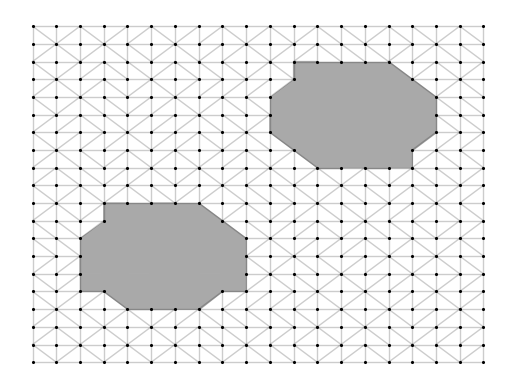

In [5]:
n_side, point_gen_mode = 20, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

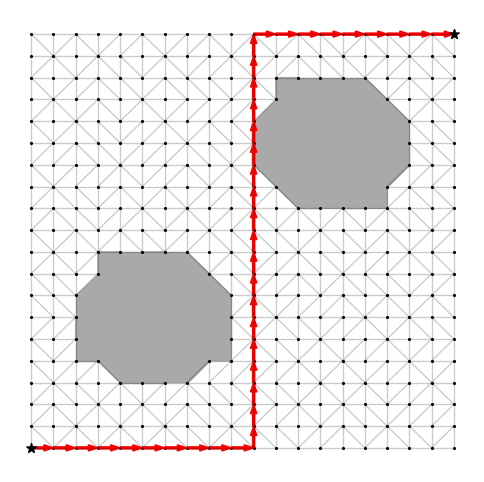

In [6]:
ref_path_coords = [(-1,-1), (0,-1), (0,1), (1,1)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_class.plot_paths('red', 'ref', figsize=(6,6))
ref_path_proj = ref_path.edge_projections[-1]

# Test

In [32]:
extra = False
path = proj_descent(SC, start, end, ref_path_proj, extra, ord=1, max_iter=100)

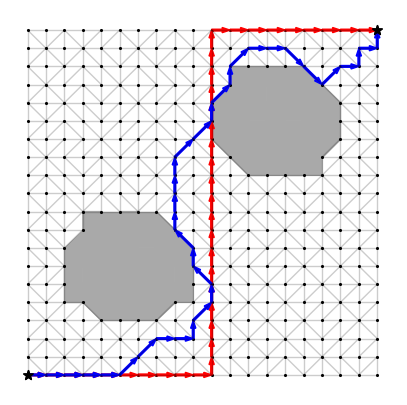

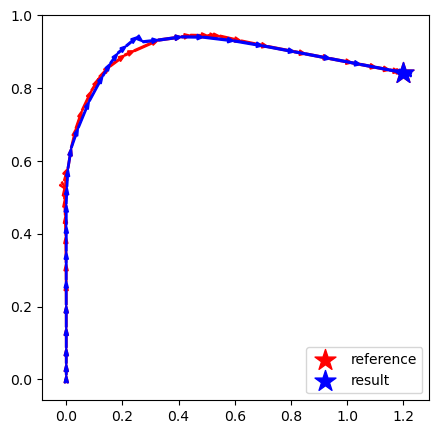

In [33]:
dijkstra_tree(SC, path, [path], ref_path_class, plot_others=False)

[6, 12, 18, 24, 30]
[6, 50, 170, 290, 391]
start = 0, end = 6
start = 6, end = 50
start = 50, end = 170
start = 170, end = 290
start = 290, end = 391
start = 391, end = 399


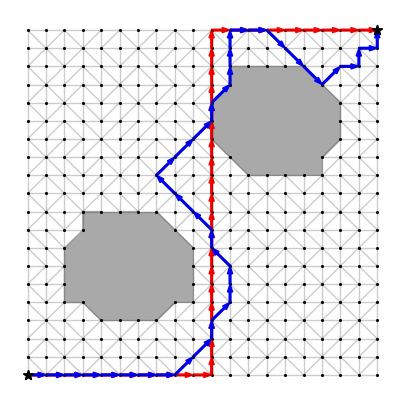

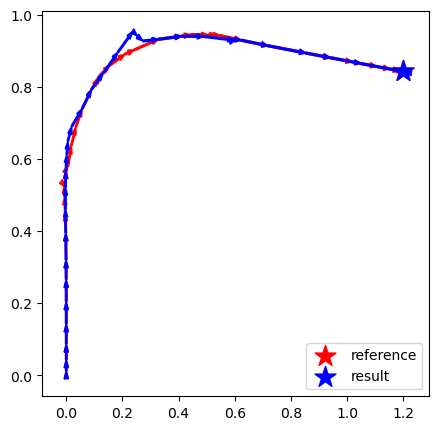

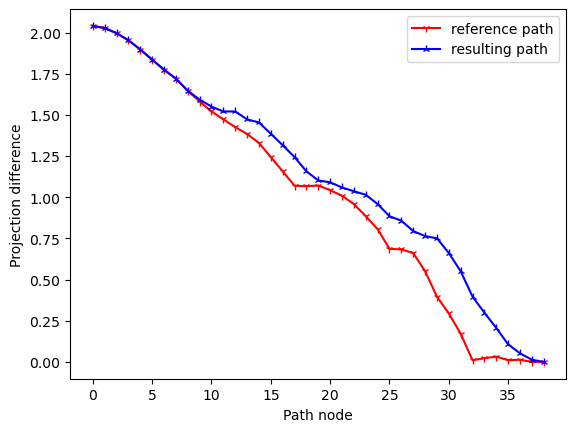

In [34]:
num_nodes = len(ref_path.nodes)
num_checkpts = 5
path = checkpoint_descent(SC, start, end, ref_path, num_checkpts=num_checkpts, extra=False, ord=1, max_iter=100)
_ = dijkstra_tree(SC, path, [path], ref_path_class, plot_others=False)
plot_proj_diff(path, ref_path)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210]
start = 0, end = 1
start = 1, end = 2
start = 2, end = 3
start = 3, end = 4
start = 4, end = 5
start = 5, end = 6
start = 6, end = 7
start = 7, end = 8
start = 8, end = 9
start = 9, end = 10
start = 10, end = 30
start = 30, end = 50
start = 50, end = 70
start = 70, end = 90
start = 90, end = 110
start = 110, end = 130
start = 130, end = 150
start = 150, end = 170
start = 170, end = 190
start = 190, end = 210
start = 210, end = 399


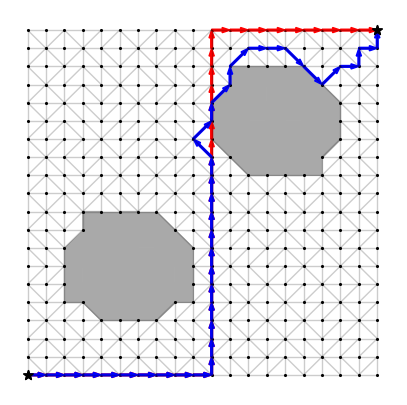

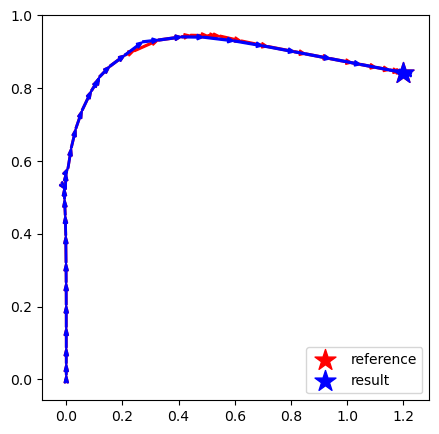

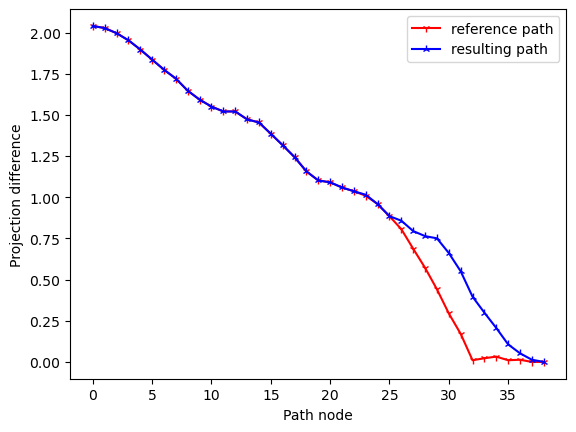

In [35]:
num_nodes = len(ref_path.nodes)
num_checkpts = 20
path = checkpoint_descent(SC, start, end, ref_path, num_checkpts=num_checkpts, extra=False, ord=1, max_iter=100)
_ = dijkstra_tree(SC, path, [path], ref_path_class, plot_others=False)
plot_proj_diff(path, ref_path)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399]
start = 0, end = 1
start = 1, end = 2
start = 2, end = 3
start = 3, end = 4
start = 4, end = 5
start = 5, end = 6
start = 6, end = 7
start = 7, end = 8
start = 8, end = 9
start = 9, end = 10
start = 10, end = 30
start = 30, end = 50
start = 50, end = 70
start = 70, end = 90
start = 90, end = 110
start = 110, end = 130
start = 130, end = 150
start = 150, end = 170
start = 170, end = 190
start = 190, end = 210
start = 210, end = 230
start = 230, end = 250
start = 250, end = 270
start = 270, end = 290
start = 290, end = 310
start = 310, end = 330
start = 330, end = 350
start = 350, end = 370
start = 370, end = 390
start = 390, end = 391
start = 391, end = 392
start = 392, end = 393


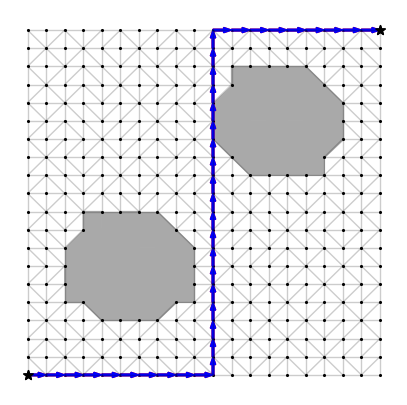

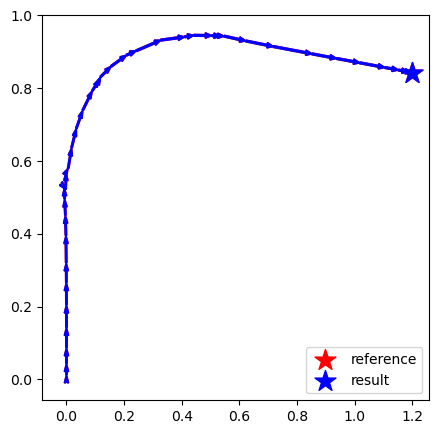

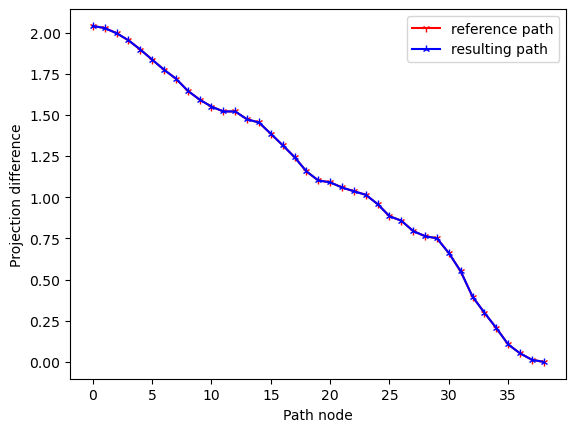

In [36]:
num_checkpts = 38
num_nodes = len(ref_path.nodes)
path = checkpoint_descent(SC, start, end, ref_path, num_checkpts=num_checkpts, extra=False, ord=1, max_iter=100)
_ = dijkstra_tree(SC, path, [path], ref_path_class, plot_others=False)
plot_proj_diff(path, ref_path)

[10, 15]
[10, 110]
start = 0, end = 10
start = 10, end = 110
start = 110, end = 399


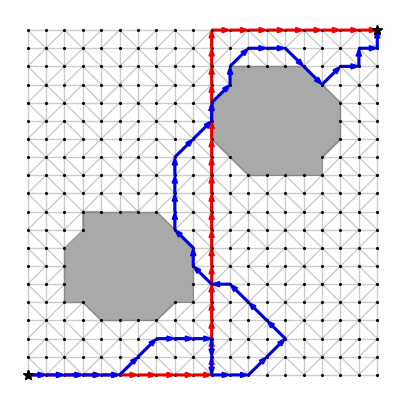

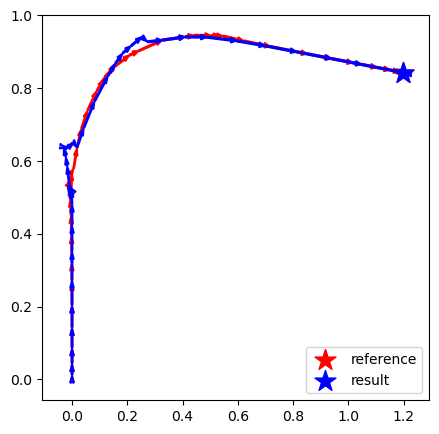

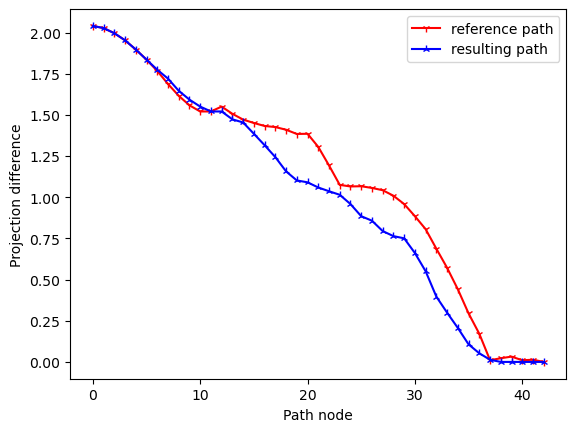

In [37]:
checkpts_idx = [10, 15]
num_nodes = len(ref_path.nodes)
path = checkpoint_descent(SC, start, end, ref_path, checkpts_idx=checkpts_idx, extra=False, ord=1, max_iter=100)
_ = dijkstra_tree(SC, path, [path], ref_path_class, plot_others=False)
plot_proj_diff(path, ref_path)

39
[1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 31, 32, 36, 37, 38]
[1, 2, 3, 4, 5, 50, 70, 90, 110, 130, 150, 170, 190, 210, 391, 392, 393, 397, 398, 399]
start = 0, end = 1
start = 1, end = 2
start = 2, end = 3
start = 3, end = 4
start = 4, end = 5
start = 5, end = 50
start = 50, end = 70
start = 70, end = 90
start = 90, end = 110
start = 110, end = 130
start = 130, end = 150
start = 150, end = 170
start = 170, end = 190
start = 190, end = 210
start = 210, end = 391
start = 391, end = 392
start = 392, end = 393
start = 393, end = 397
start = 397, end = 398
start = 398, end = 399
start = 399, end = 399


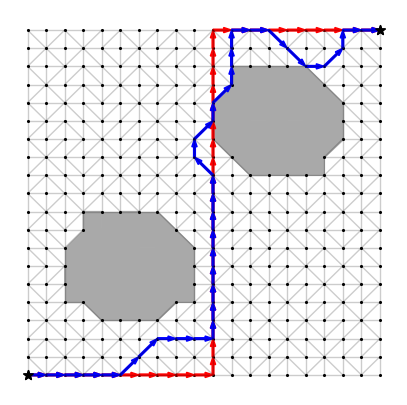

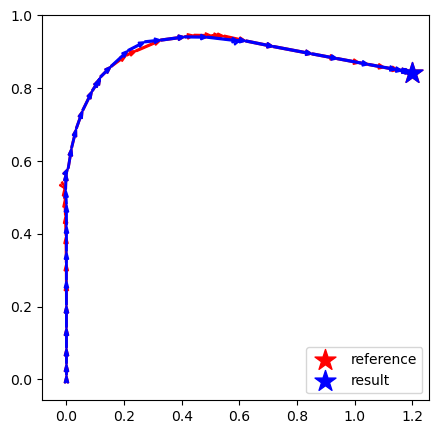

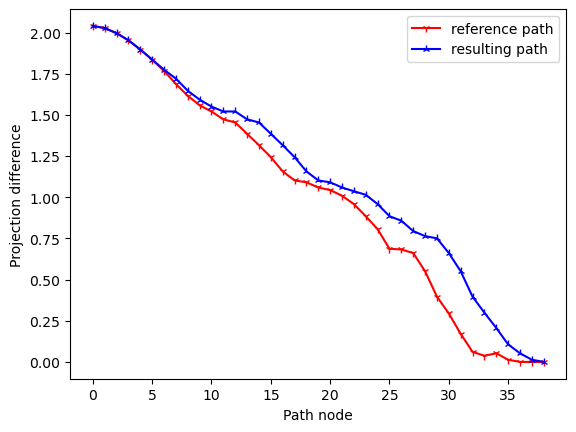

In [47]:
num_nodes = len(ref_path.nodes)
print(num_nodes)
checkpts_idx = [1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 31, 32, 36, 37, 38]
path = checkpoint_descent(SC, start, end, ref_path, checkpts_idx=checkpts_idx, extra=False, ord=1, max_iter=100)
_ = dijkstra_tree(SC, path, [path], ref_path_class, plot_others=False)
plot_proj_diff(path, ref_path)

# Exp

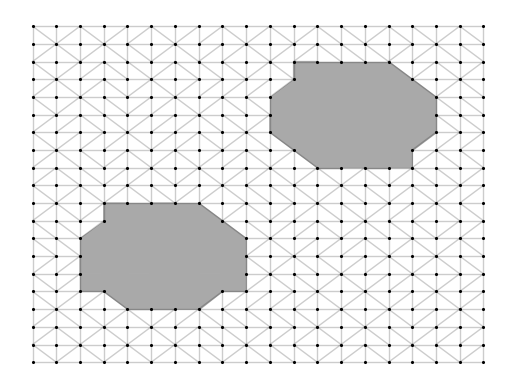

In [3]:
n_side, point_gen_mode = 20, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

In [16]:
w, v = np.linalg.eig(SC.H.T @ SC.H)

In [21]:
print(w)

[ 1.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
 -4.96692487e-17+1.02279321e-17j -4.96692487e-17-1.02279321e-17j
  5.28935097e-17+0.00000000e+00j -1.44427077e-17+4.77095119e-17j
 -1.44427077e-17-4.77095119e-17j  1.46431990e-17+4.79000420e-17j
  1.46431990e-17-4.79000420e-17j -3.62334501e-17+2.76459578e-17j
 -3.62334501e-17-2.76459578e-17j -4.29002365e-17+4.37093517e-18j
 -4.29002365e-17-4.37093517e-18j  3.66577552e-17+2.86160728e-17j
  3.66577552e-17-2.86160728e-17j  1.61384444e-18+4.15719525e-17j
  1.61384444e-18-4.15719525e-17j -1.87241849e-17+3.54494479e-17j
 -1.87241849e-17-3.54494479e-17j  2.01695344e-17+3.41075309e-17j
  2.01695344e-17-3.41075309e-17j  3.74153407e-17+0.00000000e+00j
  3.15177221e-17+2.05802270e-17j  3.15177221e-17-2.05802270e-17j
  3.00772041e-17+1.30839818e-17j  3.00772041e-17-1.30839818e-17j
 -2.30978818e-17+2.09655411e-17j -2.30978818e-17-2.09655411e-17j
 -8.38047387e-18+3.02329915e-17j -8.38047387e-18-3.02329915e-17j
  1.32466262e-17+2.819830

In [ ]:
def dijkstra_tree(SC, best_path, other_paths, ref_path_class, colors=['green', 'red', 'blue'], plot_others=False, figsize=(5,5)):
    shortest_class = Trajectory_Class(SC)
    shortest_class.add_path(best_path)
    other_class = Trajectory_Class(SC)

    for path in other_paths:
        other_class.add_path(path)

    holder = Trajectory_Holder(SC)

    if plot_others:
        holder.add_class(other_class, None, 'others', colors[0])
        
    holder.add_class(ref_path_class, None, 'reference', colors[1])
    holder.add_class(shortest_class, None, 'result', colors[2])

    holder.plot_paths(True, figsize=figsize)
    holder.plot_projections(figsize=figsize)
    plt.show()

    return holder